<a href="https://colab.research.google.com/github/llaygh/T5_camp_Amany/blob/main/Amany_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [200]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
# from mplfinance.original_flavor import candlestick_ohlc
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [116]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [117]:
df= pd.read_csv('Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [118]:
new_df = df[['date_time','traffic_volume']]
new_df

,date_time,traffic_volume
0,2017-08-27 01:00:00,1209.0
1,2018-09-06 23:00:00,1248.0
2,2017-08-25 18:00:00,4602.0
3,2017-11-09 22:00:00,2838.0
4,2017-11-09 15:00:00,5794.0
...,...,...
19995,2018-06-06 21:00:00,2723.0
19996,2017-10-25 15:00:00,5895.0
19997,2018-03-28 23:00:00,1132.0
19998,2018-02-12 15:00:00,5525.0


In [119]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       20000 non-null  object 
 1   traffic_volume  19980 non-null  float64
dtypes: float64(1), object(1)
memory usage: 312.6+ KB


In [120]:
new_df.isnull().sum()

,0
date_time,0
traffic_volume,20


In [121]:
new_df.duplicated().sum()

3721

In [122]:
(new_df['traffic_volume'] == 'nan').any()

False

In [123]:
new_df=new_df.drop_duplicates()

In [124]:
new_df['traffic_volume'] = new_df['traffic_volume'].fillna(method='bfill')

In [125]:
new_df.isnull().sum()

,0
date_time,0
traffic_volume,0


In [126]:
new_df

,date_time,traffic_volume
0,2017-08-27 01:00:00,1209.0
1,2018-09-06 23:00:00,1248.0
2,2017-08-25 18:00:00,4602.0
3,2017-11-09 22:00:00,2838.0
4,2017-11-09 15:00:00,5794.0
...,...,...
19995,2018-06-06 21:00:00,2723.0
19996,2017-10-25 15:00:00,5895.0
19997,2018-03-28 23:00:00,1132.0
19998,2018-02-12 15:00:00,5525.0


In [127]:
new_df['date_time']= pd.to_datetime(new_df['date_time'])

In [128]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16279 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       16279 non-null  datetime64[ns]
 1   traffic_volume  16279 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 897.6 KB


<Axes: >

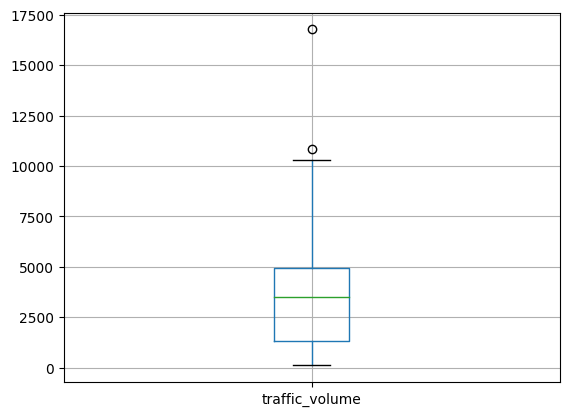

In [129]:
new_df.boxplot()

In [130]:
Q1 = new_df['traffic_volume'].quantile(0.25)
Q3 = new_df['traffic_volume'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
new_df = new_df[(new_df['traffic_volume'] >= lower_bound) & (new_df['traffic_volume']<= upper_bound)]

<Axes: >

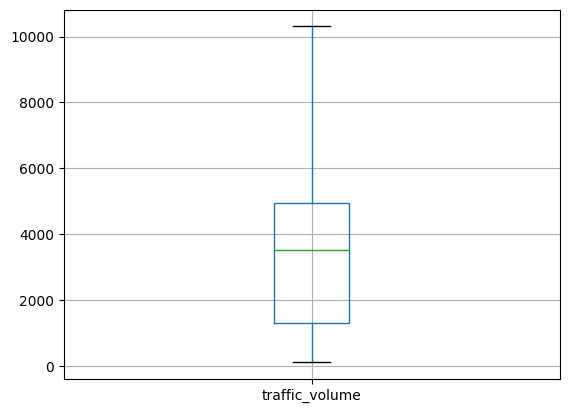

In [131]:
new_df.boxplot()

> I prepare the data set to visulize the relation no duplicate no nulls no outliers and set the acceptable format

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [132]:
new_df['Year']= new_df['date_time'].dt.year
new_df['Month'] = new_df['date_time'].dt.month

In [133]:
new_df.columns.to_list()

['date_time', 'traffic_volume', 'Year', 'Month']

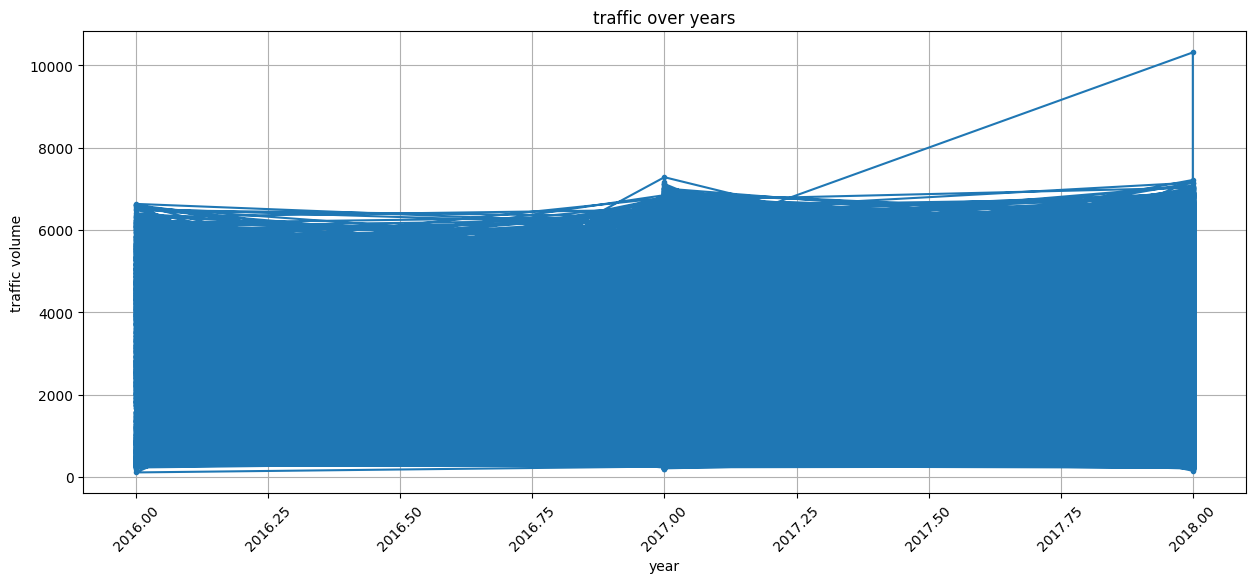

In [134]:
plt.figure(figsize=(15, 6))
plt.plot(new_df['Year'], new_df['traffic_volume'], marker='.')
plt.title('traffic over years')
plt.xlabel('year')
plt.ylabel('traffic volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

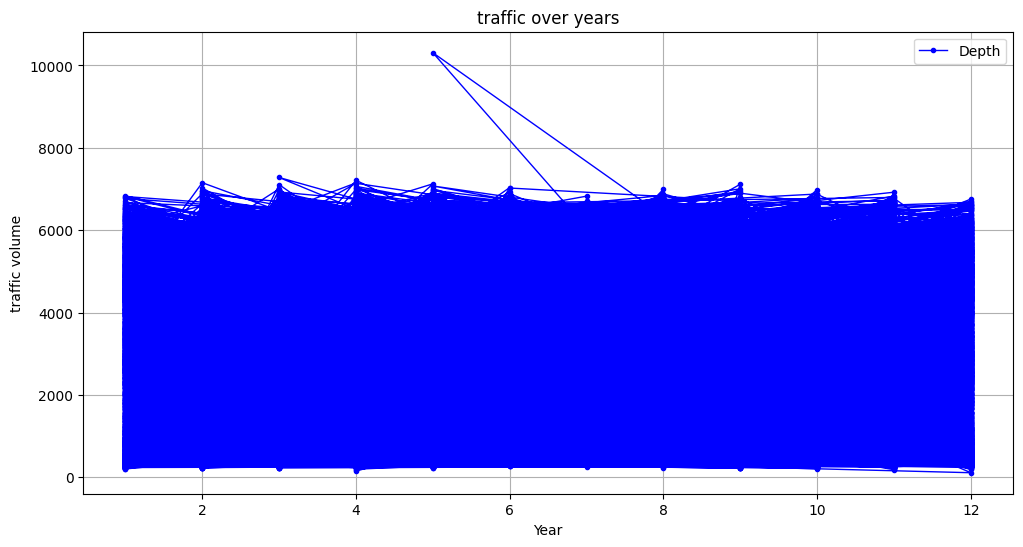

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(new_df['Month'], new_df['traffic_volume'], marker='.', linewidth=1, color='blue', label='Depth')
plt.title('traffic over years')
plt.xlabel('Year')
plt.ylabel('traffic volume')
plt.grid()
plt.legend()
plt.show()

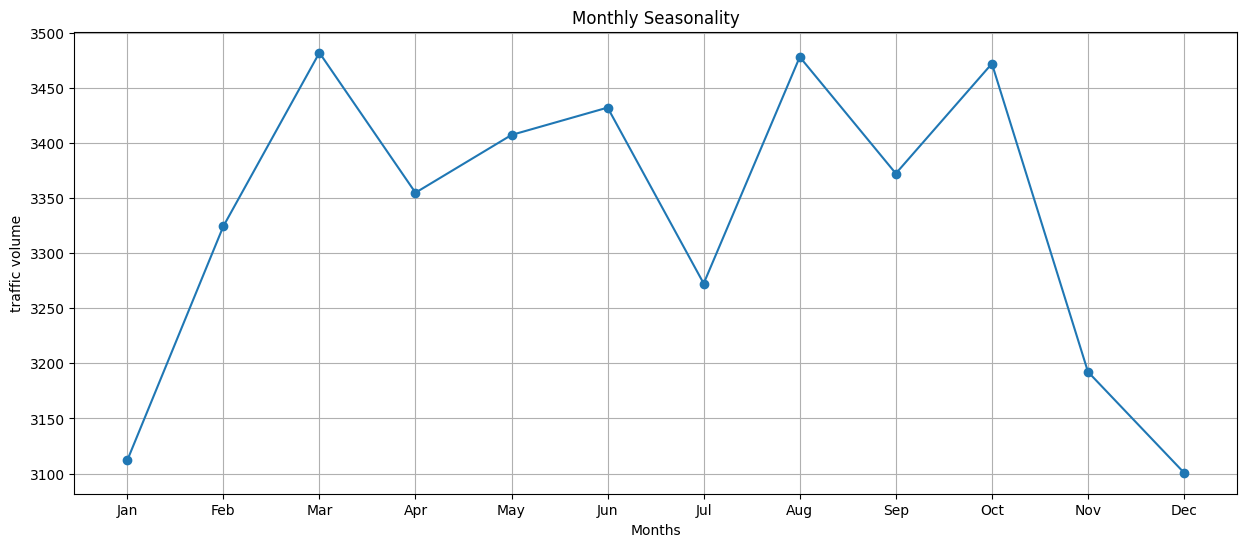

In [136]:
# Monthly Seasonality of Closing Prices
monthly_average = new_df.groupby('Month')['traffic_volume'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title('Monthly Seasonality')
plt.xlabel('Months')
plt.ylabel('traffic volume')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

> the traffic increased in january until march decrease by the end of the year

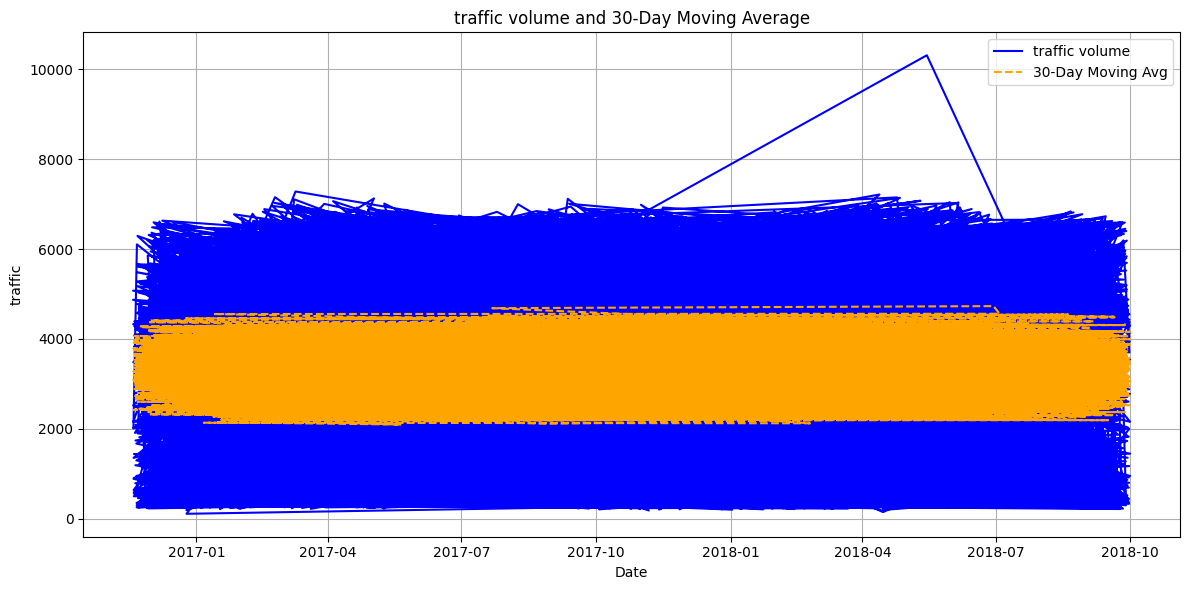

In [137]:
new_df['moving_avg'] = new_df['traffic_volume'].rolling(window=30).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(new_df['date_time'], new_df['traffic_volume'], label='traffic volume ', color='blue')
plt.plot(new_df['date_time'], new_df['moving_avg'], label='30-Day Moving Avg', linestyle='--', color='orange')
plt.title('traffic volume and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('traffic')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [138]:
seasonal_dp = new_df[['date_time','traffic_volume']]

In [139]:
seasonal_dp=seasonal_dp.set_index('date_time')

In [140]:
seasonal_dp

,traffic_volume
date_time,
2017-08-27 01:00:00,1209.0
2018-09-06 23:00:00,1248.0
2017-08-25 18:00:00,4602.0
2017-11-09 22:00:00,2838.0
2017-11-09 15:00:00,5794.0
...,...
2018-06-06 21:00:00,2723.0
2017-10-25 15:00:00,5895.0
2018-03-28 23:00:00,1132.0


In [141]:
seasonal_dp['traffic_volume'] = seasonal_dp['traffic_volume'].astype(int)

In [142]:
# # ETS Decomposition
# result = seasonal_decompose(x='date_time',seasonal_dp['traffic_volume'],
#                             model ='multiplicative')
# result.plot()

> positional argument follows keyword argument this error appear

In [143]:
# import statsmodels as sm
# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(seasonal_decompose['traffic_volume'], model = 'additive')
# fig = decomposition.plot()
# matplotlib.rcParams['figure.figsize'] = [9.0,5.0]

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [146]:
new_df['Day_of_Week'] = new_df['date_time'].dt.dayofweek  # 0=Monday, 6=Sunday
new_df['Day_of_Year'] = new_df['date_time'].dt.dayofyear
new_df['IsWeekend'] = (new_df['Day_of_Week'] >= 5).astype(int)  # 1 if Saturday/Sunday, else 0

In [147]:
new_df = new_df.sort_values('date_time')

<Figure size 1000x600 with 0 Axes>

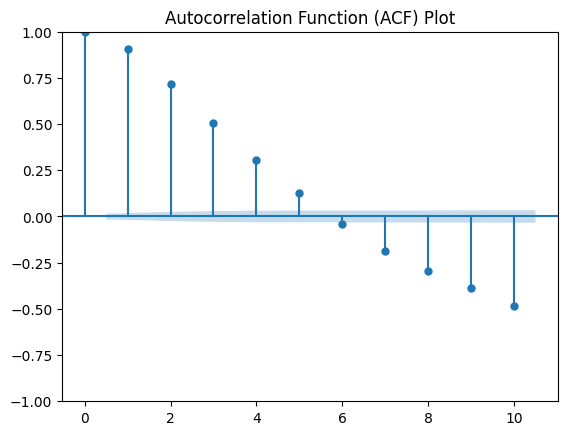

In [148]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(new_df['traffic_volume'], lags=10)  # Adjust the number of lags as necessary
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

In [158]:
# from the prev graph i will do a one lag
# but first i will male a df contains the target 'traffic_volume'

lag_df = new_df[['date_time','traffic_volume']].sort_values(by='date_time')
lag_df

,date_time,traffic_volume
4628,2016-11-18 15:00:00,4872.0
3867,2016-11-18 16:00:00,5074.0
6235,2016-11-18 17:00:00,4328.0
2646,2016-11-18 18:00:00,3486.0
2062,2016-11-18 19:00:00,2524.0
...,...,...
6605,2018-09-30 19:00:00,3543.0
14241,2018-09-30 20:00:00,2781.0
9500,2018-09-30 21:00:00,2159.0
15201,2018-09-30 22:00:00,1450.0


In [161]:
lag_df['prev_traffic_volume']= lag_df['traffic_volume'].shift(1)
lag_df

,date_time,traffic_volume,prev_traffic_volume
4628,2016-11-18 15:00:00,4872.0,NaN
3867,2016-11-18 16:00:00,5074.0,4872.0
6235,2016-11-18 17:00:00,4328.0,5074.0
2646,2016-11-18 18:00:00,3486.0,4328.0
2062,2016-11-18 19:00:00,2524.0,3486.0
...,...,...,...
6605,2018-09-30 19:00:00,3543.0,3947.0
14241,2018-09-30 20:00:00,2781.0,3543.0
9500,2018-09-30 21:00:00,2159.0,2781.0
15201,2018-09-30 22:00:00,1450.0,2159.0


In [163]:
lag_df['Time'] = np.arange(len(lag_df.index))

lag_df.head()

,date_time,traffic_volume,prev_traffic_volume,Time
4628,2016-11-18 15:00:00,4872.0,NaN,0
3867,2016-11-18 16:00:00,5074.0,4872.0,1
6235,2016-11-18 17:00:00,4328.0,5074.0,2
2646,2016-11-18 18:00:00,3486.0,4328.0,3
2062,2016-11-18 19:00:00,2524.0,3486.0,4


In [166]:
lag_df = lag_df.set_index('date_time')


KeyError: "None of ['date_time'] are in the columns"

In [167]:
lag_df.head()

,traffic_volume,prev_traffic_volume,Time
date_time,,,
2016-11-18 15:00:00,4872.0,NaN,0
2016-11-18 16:00:00,5074.0,4872.0,1
2016-11-18 17:00:00,4328.0,5074.0,2
2016-11-18 18:00:00,3486.0,4328.0,3
2016-11-18 19:00:00,2524.0,3486.0,4


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [160]:
new_df #here is the feature created from the columns 'date_time' and 'traffic_volume'

,date_time,traffic_volume,Year,Month,moving_avg,Day_of_Week,Day_of_Year,IsWeekend
4628,2016-11-18 15:00:00,4872.0,2016,11,3420.200000,4,323,0
3867,2016-11-18 16:00:00,5074.0,2016,11,3354.166667,4,323,0
6235,2016-11-18 17:00:00,4328.0,2016,11,2974.833333,4,323,0
2646,2016-11-18 18:00:00,3486.0,2016,11,3278.133333,4,323,0
2062,2016-11-18 19:00:00,2524.0,2016,11,3098.666667,4,323,0
...,...,...,...,...,...,...,...,...
6605,2018-09-30 19:00:00,3543.0,2018,9,2780.866667,6,273,1
14241,2018-09-30 20:00:00,2781.0,2018,9,3455.000000,6,273,1
9500,2018-09-30 21:00:00,2159.0,2018,9,4157.900000,6,273,1
15201,2018-09-30 22:00:00,1450.0,2018,9,3170.566667,6,273,1


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [172]:
# using lag_df

X = lag_df.loc[:, ['prev_traffic_volume']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = lag_df.loc[:, 'traffic_volume']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# model = LinearRegression()
# model.fit(X, y)

# y_pred = pd.Series(model.predict(X), index=X.index)

In [173]:
X

,prev_traffic_volume
date_time,
2016-11-18 16:00:00,4872.0
2016-11-18 17:00:00,5074.0
2016-11-18 18:00:00,4328.0
2016-11-18 19:00:00,3486.0
2016-11-18 20:00:00,2524.0
...,...
2018-09-30 19:00:00,3947.0
2018-09-30 20:00:00,3543.0
2018-09-30 21:00:00,2781.0


In [174]:
y

,traffic_volume
date_time,
2016-11-18 16:00:00,5074.0
2016-11-18 17:00:00,4328.0
2016-11-18 18:00:00,3486.0
2016-11-18 19:00:00,2524.0
2016-11-18 20:00:00,2027.0
...,...
2018-09-30 19:00:00,3543.0
2018-09-30 20:00:00,2781.0
2018-09-30 21:00:00,2159.0


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [176]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array(X).reshape(-1,1))

X = scaler.transform(np.array(X).reshape(-1,1))
y = scaler.transform(np.array(y).reshape(-1,1))

In [177]:
X.shape

(16294, 1)

In [178]:
# Reshape X for RNN [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [179]:
X.shape

(16294, 1, 1)

In [187]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [188]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')


### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [189]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=5,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0156 - val_loss: 0.0066
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 0.0066


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [190]:
# Let's do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [191]:
model.predict(X_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.4268426 ],
       [0.44798425],
       [0.04466462],
       [0.3779872 ],
       [0.49369845]], dtype=float32)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [192]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [193]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

3789.902304989934
3787.473118685414


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [209]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

In [207]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [210]:
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 1 and 10 for '{{node sequential_5_1/lstm_2_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_5_1/lstm_2_1/strided_slice_1, sequential_5_1/lstm_2_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,1], [10,16].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 1), dtype=float32)
  • states=('tf.Tensor(shape=(1, 4), dtype=float32)', 'tf.Tensor(shape=(1, 4), dtype=float32)')
  • training=True

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

Epoch 1/5


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 1 and 10 for '{{node sequential_3_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/lstm_1/strided_slice_2, sequential_3_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,1], [10,16].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
  • states=('tf.Tensor(shape=(None, 4), dtype=float32)', 'tf.Tensor(shape=(None, 4), dtype=float32)')
  • training=True

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: